In [56]:
import matplotlib.pyplot as plt
import control as ct
import numpy as np
import os
import pandas as pd

nombre_archivo = r"resultadosMn.txt"
t_step = 0.1

if not os.path.exists(nombre_archivo):
    print(f"ERROR: No se encuentra el archivo en: {nombre_archivo}")
else:
    try:
        datos = np.loadtxt(nombre_archivo, delimiter=',')
        
        t = datos[:, 0]  
        y = datos[:, 1]  

        print(f"Datos cargados. Total: {len(y)}")

        mask_inicial = (t > 0.09) & (t < t_step)
        
        y_final_slice = y[-50:] 

        if np.any(mask_inicial):
            y_ss1 = np.mean(y[mask_inicial])
            y_ss2 = np.mean(y_final_slice)
            
            print("-" * 30)
            print(f"Voltaje Inicial (y_ss1): {y_ss1:.4f} V  (Promedio entre 0.09s y {t_step}s)")
            print(f"Voltaje Final   (y_ss2): {y_ss2:.4f} V  (Últimos 50 datos)")
            print("-" * 30)            
        else:
            print("ERROR: No se encontraron datos en el intervalo 0.09s - 0.1s.")

    except Exception as e:
        print(f"Ocurrió un error: {e}")

Datos cargados. Total: 2001
------------------------------
Voltaje Inicial (y_ss1): 14.0564 V  (Promedio entre 0.09s y 0.1s)
Voltaje Final   (y_ss2): 18.2989 V  (Últimos 50 datos)
------------------------------



Parámetros de inflexión:
  Derivada máxima (m)         = 729.3501 V/s
  Tiempo de inflexión (t_inf) = 0.10 s
  Voltaje de inflexión (y_inf) = 14.212 V

Tiempos calculados (método de la tangente):
  t_L (intersección inferior) = 0.10009 s
  t_T (intersección superior) = 0.10590 s

--- PARÁMETROS FOPDT OBTENIDOS ---
  K = -106.06326198204496
  L = 8.648434590784182e-05 s
  T = 0.005816863897313743 s


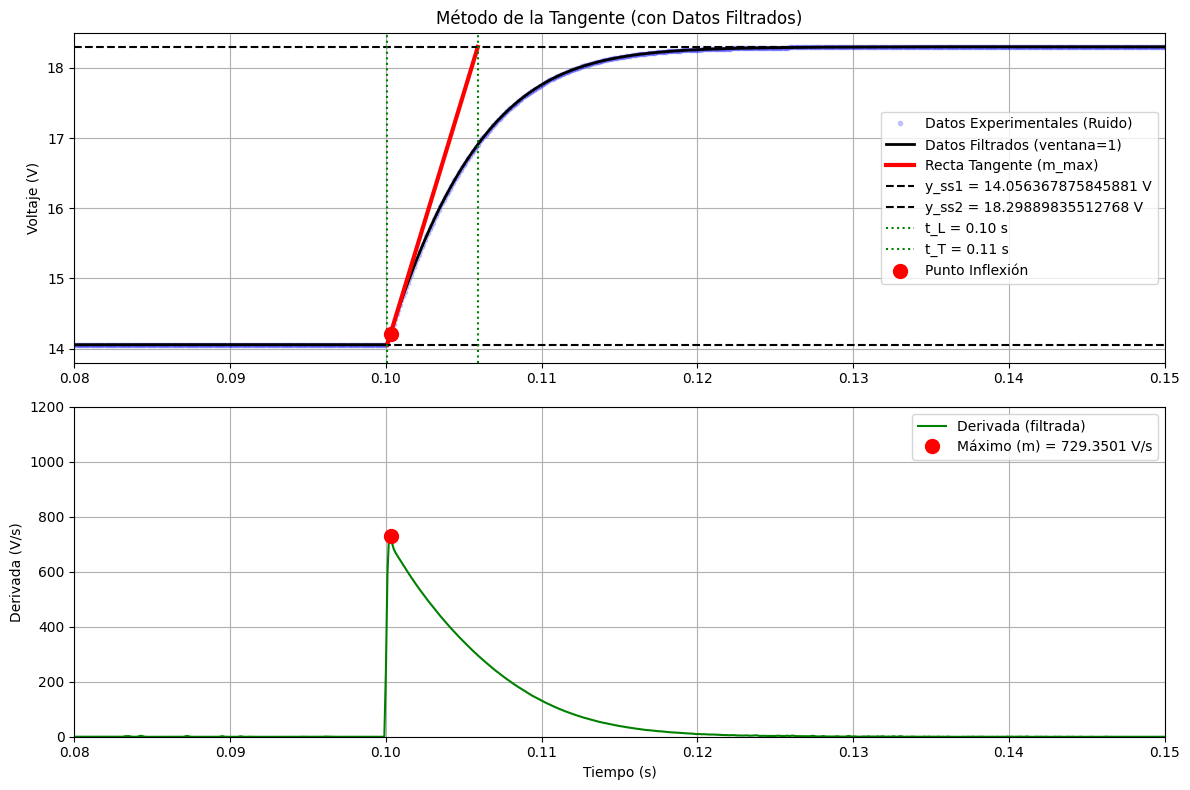

In [57]:
delta_u = -0.04    
t_0 = 0.1  

window_size = 1

try:
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo', 'V_pv'])
    
    data['t_seg'] = data['Tiempo'] 
    data['y_voltaje_filtrado'] = data['V_pv'].rolling(window=window_size, center=True).mean()
    
    data = data.dropna()
    
    t_seg = data['t_seg'].to_numpy()
    y_voltaje_ruido = data['V_pv'].to_numpy()       
    y_voltaje_filtrado = data['y_voltaje_filtrado'].to_numpy() 
    
    dy = np.diff(y_voltaje_filtrado)
    dt = np.diff(t_seg)
    
    dt[dt == 0] = 1e-9
    
    derivada = dy / dt
    
    t_derivada = t_seg[:-1] 

    mask_escalon = t_derivada > t_step

    if not np.any(mask_escalon):
        raise ValueError("No hay datos después del escalón para analizar la derivada.")

    deriv_escalon = derivada[mask_escalon]
    t_deriv_escalon = t_derivada[mask_escalon]

    m = np.max(deriv_escalon)
    idx_rel = np.argmax(deriv_escalon)

    idx_max = np.where(mask_escalon)[0][idx_rel]

    t_inflexion = t_derivada[idx_max]
    y_inflexion = y_voltaje_filtrado[idx_max]

    t_L = t_inflexion + (y_ss1 - y_inflexion) / m
    t_T = t_inflexion + (y_ss2 - y_inflexion) / m
    
    L = t_L - t_0
    
    T = t_T - t_L
    
    K = (y_ss2 - y_ss1) / delta_u

    print("\nParámetros de inflexión:")
    print(f"  Derivada máxima (m)         = {m:.4f} V/s")
    print(f"  Tiempo de inflexión (t_inf) = {t_inflexion:.2f} s")
    print(f"  Voltaje de inflexión (y_inf) = {y_inflexion:.3f} V")
    
    print("\nTiempos calculados (método de la tangente):")
    print(f"  t_L (intersección inferior) = {t_L:.5f} s")
    print(f"  t_T (intersección superior) = {t_T:.5f} s")

    print("\n--- PARÁMETROS FOPDT OBTENIDOS ---")
    print(f"  K = {K}")
    print(f"  L = {L} s")
    print(f"  T = {T} s")


    b_tangente = y_inflexion - m * t_inflexion
    t_graf_tangente = np.array([t_L, t_T])
    y_graf_tangente = m * t_graf_tangente + b_tangente

    plt.figure(figsize=(12, 8))
    
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_seg, y_voltaje_ruido, 'b.', label='Datos Experimentales (Ruido)', alpha=0.2)
    ax1.plot(t_seg, y_voltaje_filtrado, 'k-', linewidth=2, label=f'Datos Filtrados (ventana={window_size})')
    
    ax1.plot(t_graf_tangente, y_graf_tangente, 'r-', linewidth=3, label='Recta Tangente (m_max)')
    ax1.axhline(y=y_ss1, color='k', linestyle='--', label=f'y_ss1 = {y_ss1} V')
    ax1.axhline(y=y_ss2, color='k', linestyle='--', label=f'y_ss2 = {y_ss2} V')
    ax1.axvline(x=t_L, color='g', linestyle=':', label=f't_L = {t_L:.2f} s')
    ax1.axvline(x=t_T, color='g', linestyle=':', label=f't_T = {t_T:.2f} s')
    ax1.plot(t_inflexion, y_inflexion, 'ro', markersize=10, label='Punto Inflexión')
    
    ax1.set_title('Método de la Tangente (con Datos Filtrados)')
    ax1.set_ylabel('Voltaje (V)')
    ax1.legend()
    ax1.grid(True)

    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(t_derivada, derivada, 'g-', label='Derivada (filtrada)') 
    ax2.plot(t_inflexion, m, 'ro', markersize=10, label=f'Máximo (m) = {m:.4f} V/s')
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Derivada (V/s)')
    ax2.legend()
    ax2.grid(True)
    
    zoom_inicio = t_step - 0.02
    zoom_fin    = t_step + 0.05

    ax1.set_xlim(zoom_inicio, zoom_fin)
    ax1.set_ylim(13.8, 18.5)
    
    ax2.set_xlim(zoom_inicio, zoom_fin)
    ax2.set_ylim(0, 1200)

    
    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo}'")
    print("Por favor, asegúrese que el archivo .txt está en la misma carpeta que el script.")
    
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")


Parámetros de inflexión:
  Derivada máxima (m)         = 729.3501 V/s
  Tiempo de inflexión (t_inf) = 0.10 s
  Voltaje de inflexión (y_inf) = 14.212 V

Tiempos calculados (método de la tangente):
  t_L (intersección inferior) = 0.10009 s
  t_T (intersección superior) = 0.10590 s

--- PARÁMETROS FOPDT OBTENIDOS ---
  K = -106.06326198204496
  L = 8.648434590784182e-05 s
  T = 0.005816863897313743 s


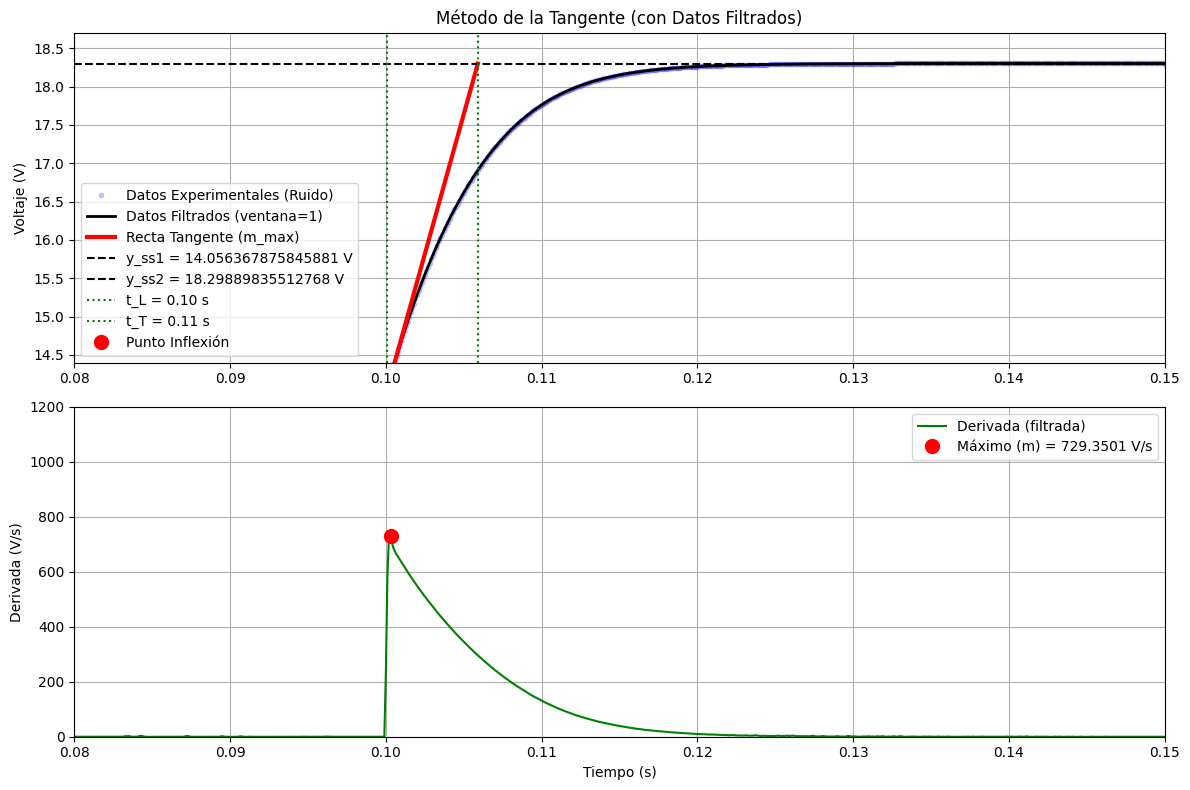

In [58]:

delta_u = -0.04    
t_0 = 0.1  

window_size = 1

try:
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo', 'V_pv'])
    
    data['t_seg'] = data['Tiempo'] 

    data['y_voltaje_filtrado'] = data['V_pv'].rolling(window=window_size, center=True).mean()
    
    data = data.dropna()
    
    t_seg = data['t_seg'].to_numpy()
    y_voltaje_ruido = data['V_pv'].to_numpy()       
    y_voltaje_filtrado = data['y_voltaje_filtrado'].to_numpy() 
    

    dy = np.diff(y_voltaje_filtrado)
    dt = np.diff(t_seg)
    
    dt[dt == 0] = 1e-9
    
    derivada = dy / dt
    
    t_derivada = t_seg[:-1]

    mask_escalon = t_derivada > t_step

    if not np.any(mask_escalon):
        raise ValueError("No hay datos después del escalón para analizar la derivada.")

    deriv_escalon = derivada[mask_escalon]
    t_deriv_escalon = t_derivada[mask_escalon]

    m = np.max(deriv_escalon)
    idx_rel = np.argmax(deriv_escalon)

    idx_max = np.where(mask_escalon)[0][idx_rel]

    t_inflexion = t_derivada[idx_max]
    y_inflexion = y_voltaje_filtrado[idx_max]


    t_L = t_inflexion + (y_ss1 - y_inflexion) / m
    t_T = t_inflexion + (y_ss2 - y_inflexion) / m
    
    L = t_L - t_0
    
    T = t_T - t_L
    
    K = (y_ss2 - y_ss1) / delta_u
   
    print("\nParámetros de inflexión:")
    print(f"  Derivada máxima (m)         = {m:.4f} V/s")
    print(f"  Tiempo de inflexión (t_inf) = {t_inflexion:.2f} s")
    print(f"  Voltaje de inflexión (y_inf) = {y_inflexion:.3f} V")
    
    print("\nTiempos calculados (método de la tangente):")
    print(f"  t_L (intersección inferior) = {t_L:.5f} s")
    print(f"  t_T (intersección superior) = {t_T:.5f} s")

    print("\n--- PARÁMETROS FOPDT OBTENIDOS ---")
    print(f"  K = {K}")
    print(f"  L = {L} s")
    print(f"  T = {T} s")


    b_tangente = y_inflexion - m * t_inflexion
    t_graf_tangente = np.array([t_L, t_T])
    y_graf_tangente = m * t_graf_tangente + b_tangente

    plt.figure(figsize=(12, 8))
    
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_seg, y_voltaje_ruido, 'b.', label='Datos Experimentales (Ruido)', alpha=0.2)
    ax1.plot(t_seg, y_voltaje_filtrado, 'k-', linewidth=2, label=f'Datos Filtrados (ventana={window_size})')
    
    ax1.plot(t_graf_tangente, y_graf_tangente, 'r-', linewidth=3, label='Recta Tangente (m_max)')
    ax1.axhline(y=y_ss1, color='k', linestyle='--', label=f'y_ss1 = {y_ss1} V')
    ax1.axhline(y=y_ss2, color='k', linestyle='--', label=f'y_ss2 = {y_ss2} V')
    ax1.axvline(x=t_L, color='g', linestyle=':', label=f't_L = {t_L:.2f} s')
    ax1.axvline(x=t_T, color='g', linestyle=':', label=f't_T = {t_T:.2f} s')
    ax1.plot(t_inflexion, y_inflexion, 'ro', markersize=10, label='Punto Inflexión')
    
    ax1.set_title('Método de la Tangente (con Datos Filtrados)')
    ax1.set_ylabel('Voltaje (V)')
    ax1.legend()
    ax1.grid(True)

    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(t_derivada, derivada, 'g-', label='Derivada (filtrada)') 
    ax2.plot(t_inflexion, m, 'ro', markersize=10, label=f'Máximo (m) = {m:.4f} V/s')
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Derivada (V/s)')
    ax2.legend()
    ax2.grid(True)
    
    zoom_inicio = t_step - 0.02
    zoom_fin    = t_step + 0.05

    ax1.set_xlim(zoom_inicio, zoom_fin)
    ax1.set_ylim(14.4, 18.7)
    
    ax2.set_xlim(zoom_inicio, zoom_fin)
    ax2.set_ylim(0, 1200)

    
    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo}'")
    print("Por favor, asegúrese que el archivo .txt está en la misma carpeta que el script.")
    
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")

In [59]:

print(f"K = {K}")
print(f"L = {L}")
print(f"T = {T}")

num = [-106.06]
den = [0.005, 1]

Gp = ct.tf(num,den)

print("\nFunción de Transferencia de la Planta Gp(s):")
print(Gp)

K = -106.06326198204496
L = 8.648434590784182e-05
T = 0.005816863897313743

Función de Transferencia de la Planta Gp(s):
<TransferFunction>: sys[151]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    -106.1
  -----------
  0.005 s + 1


### Reglas de Sintonización de Ziegler-Nichols (Lazo Abierto)

Ziegler y Nichols propusieron una tabla de sintonización empírica basada en los parámetros $K$, $L$ y $T$ de la curva S.

**Tabla de Sintonización de Ziegler-Nichols (Método 1):**

| Tipo de Controlador | $K_p$ | $T_i$ | $T_d$ |
| :--- | :--- | :--- | :--- |
| P | $T / (K \cdot L)$ | $\infty$ | $0$ |
| PI | $0.9 \cdot T / (K \cdot L)$ | $L / 0.3$ | $0$ |
| **PID** | **$1.2 \cdot T / (K \cdot L)$** | **$2L$** | **$0.5L$** |

Usaremos las fórmulas de la fila **PID**. Las conversiones de $T_i$ y $T_d$ a las ganancias $K_i$ y $K_d$ son:

* $K_i = K_p / T_i$
* $K_d = K_p \cdot T_d$

In [60]:

print(f"K = {K}")
print(f"L = {L}")
print(f"T = {T}")

L1 = L
K1 = K
T1 = K
Kp_zn = (1.2 * T) / (K * L)
Ti_zn = 2 * L
Td_zn = 0.5 * L


print("\nVALOR DE Ti: ")
print(Ti_zn)
print("\nVALOR DE Td: ")
print(Td_zn)

Ki_zn = Kp_zn / Ti_zn
Kd_zn = Kp_zn * Td_zn

print("\n--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_zn}")
print(f"Ki = {Ki_zn}")
print(f"Kd = {Kd_zn}")

K = -106.06326198204496
L = 8.648434590784182e-05
T = 0.005816863897313743

VALOR DE Ti: 
0.00017296869181568364

VALOR DE Td: 
4.324217295392091e-05

--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = -0.7609702238019996
Ki = -4399.4679951265025
Kd = -3.290600603042997e-05



--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = -0.7609702238019996
Ki = -4399.4679951265025
Kd = -3.290600603042997e-05

Función de Transferencia del sistema de lazon cerrado con controlador Proporcional-Integral-Derivativo:
<TransferFunction>: sys[155]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  0.00349 s^2 + 80.71 s + 4.666e+05
  ---------------------------------
  0.00849 s^2 + 81.71 s + 4.666e+05

Las raíces de s (polos) del sistema controlado son:
[-4812.03746028+5639.49391324j -4812.03746028-5639.49391324j]


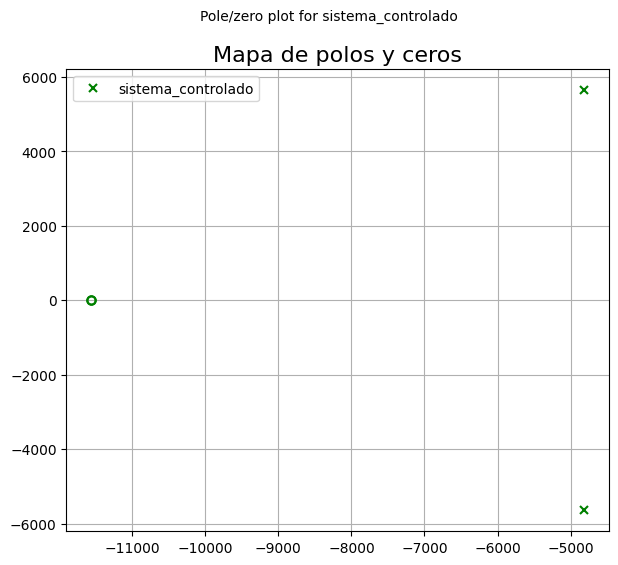

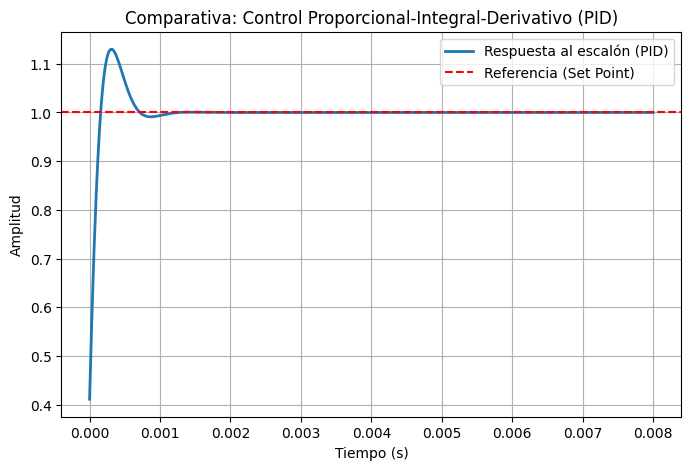

Métricas de desempeño del sistema con controlador Proporcional-Integral-Derivativo:
  - Sobreimpulso (Overshoot): 12.99%
  - Tiempo de establecimiento (SettlingTime): 0.00 s
  - Valor final: 1.0000
  - Error en estado estacionario (1 - valor_final): 0.0000


In [61]:

print("\n--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_zn}")
print(f"Ki = {Ki_zn}")
print(f"Kd = {Kd_zn}")

Kd = Kd_zn * 1
Kp = Kp_zn * 1
Ki = Ki_zn * 1

Gc_zn = ct.tf([Kd, Kp, Ki], [1, 0])

sistema_PID = ct.feedback(Gc_zn * Gp, 1)

t_sim, y_unit_step = ct.step_response(sistema_PID, T=np.linspace(0, 5, 1000))

print("\nFunción de Transferencia del sistema de lazon cerrado con controlador Proporcional-Integral-Derivativo:")
print(sistema_PID)

polos_PID = ct.poles(sistema_PID)

t = np.linspace(0, 0.008, 501)
t_PID, y_PID = ct.step_response(sistema_PID, T=t)

print("\nLas raíces de s (polos) del sistema controlado son:")
print(polos_PID)


plt.figure(figsize=(7, 6))
plt.title('Mapa de polos y ceros', fontsize=16)
ct.pzmap(sistema_PID, label="sistema_controlado", color='green')
plt.grid(True)
plt.legend()
plt.show() 

plt.figure(figsize=(8, 5))
plt.title("Comparativa: Control Proporcional-Integral-Derivativo (PID)")

plt.plot(t_PID, y_PID, label="Respuesta al escalón (PID)", linewidth=2)

plt.axhline(y=1, color='red', linestyle='--', label="Referencia (Set Point)")

plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()

# ... (Tu código de métricas sigue igual)
print("Métricas de desempeño del sistema con controlador Proporcional-Integral-Derivativo:")
info = ct.step_info(sistema_PID)
print(f"  - Sobreimpulso (Overshoot): {info['Overshoot']:.2f}%")
print(f"  - Tiempo de establecimiento (SettlingTime): {info['SettlingTime']:.2f} s")
valor_final = y_PID[-1]
print(f"  - Valor final: {valor_final:.4f}")
print(f"  - Error en estado estacionario (1 - valor_final): {1 - valor_final:.4f}")


In [62]:

print("\n--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_zn}")
print(f"Ki = {Ki_zn}")
print(f"Kd = {Kd_zn}")

Kd = Kd_zn * 1
Kp = Kp_zn * 1
Ki = Ki_zn * 0.25

N = 10 

Tf = Kd / (Kp * N) 

Cp = ct.tf([Kp], [1])

Ci = ct.tf([Ki], [1, 0])

Cd_filt = ct.tf([Kd, 0], [Tf, 1])

Gc_real = Cp + Ci + Cd_filt

sistema_PID = ct.feedback(Gc_real * Gp, 1)

print("\nFunción de Transferencia del Controlador PID (con filtro):")
print(Gc_real)

t_sim, y_unit_step = ct.step_response(sistema_PID, T=np.linspace(0, 5, 501))

print("\nFunción de Transferencia del sistema de lazon cerrado con controlador Proporcional-Integral-Derivativo:")
print(sistema_PID)

polos_PID = ct.poles(sistema_PID)

t = np.linspace(0, 0.008, 501)
t_PID, y_PID = ct.step_response(sistema_PID, T=t)


print("\nMétricas de desempeño del sistema con controlador Proporcional-Integral-Derivativo:")
info = ct.step_info(sistema_PID)
print(f"  - Sobreimpulso (Overshoot): {info['Overshoot']:.2f}%")
print(f"  - Tiempo de establecimiento (SettlingTime): {info['SettlingTime']:.2f} s")
valor_final = y_PID[-1]
print(f"  - Valor final: {valor_final:.4f}")
print(f"  - Error en estado estacionario (1 - valor_final): {1 - valor_final:.4f}")



--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = -0.7609702238019996
Ki = -4399.4679951265025
Kd = -3.290600603042997e-05

Función de Transferencia del Controlador PID (con filtro):
<TransferFunction>: sys[164]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  -3.62e-05 s^2 - 0.7657 s - 1100
  -------------------------------
         4.324e-06 s^2 + s

Función de Transferencia del sistema de lazon cerrado con controlador Proporcional-Integral-Derivativo:
<TransferFunction>: sys[167]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

          0.003839 s^2 + 81.21 s + 1.167e+05
  --------------------------------------------------
  2.162e-08 s^3 + 0.008843 s^2 + 82.21 s + 1.167e+05

Métricas de desempeño del sistema con controlador Proporcional-Integral-Derivativo:
  - Sobreimpulso (Overshoot): 4.72%
  - Tiempo de establecimiento (SettlingTime): 0.00 s
  - Valor final: 1.0000
  - Error en estado estacionario (1 - valor_final): -0.0000


In [63]:
K_planta = K 
T_planta = T

ts_deseado = 0.005   
zeta = 0.9          

# Criterio del 2% para tiempo de asentamiento: ts = 4 / (zeta * wn)
wn = 4 / (zeta * ts_deseado)

Kp_calc = (2 * zeta * wn * T_planta - 1) / K_planta
Ki_calc = (wn**2 * T_planta) / K_planta
Kd_calc = 0  

print(f"--- RESULTADOS DE ASIGNACIÓN DE POLOS ---")
print(f"  Kp = {Kp_calc:.6f}")
print(f"  Ki = {Ki_calc:.6f}")
print(f"  Kd = {Kd_calc:.6f}")

# Gc(s) = Kp + Ki/s = (Kp*s + Ki) / s
num_c = [Kp_calc, Ki_calc]
den_c = [1, 0]
Gc = ct.tf(num_c, den_c)

# H(s) = (Gc*Gp) / (1 + Gc*Gp)
H_closed_loop = ct.feedback(Gc * Gp, 1)

t_sim = np.linspace(0, ts_deseado * 2, 1000)
t, y = ct.step_response(H_closed_loop, T=t_sim)

polos = ct.poles(H_closed_loop)

print("\n POLOS DEL SISTEMA CERRADO ")
print(polos)


info_tuned = ct.step_info(H_closed_loop)
print("\nInformación de la respuesta (Sintonizada, escalón unitario):")
print(f"  - Sobreimpulso (Overshoot): {info_tuned['Overshoot']:.2f}%")
print(f"  - Tiempo de Establecimiento (SettlingTime): {info_tuned['SettlingTime']:.2f} s")
valor_final = y[-1]
print(f"  - Valor final: {valor_final:.4f}")
print(f"  -Error en estado estacionario (1 -  valor_final): {1 - valor_final:.4f}")


--- RESULTADOS DE ASIGNACIÓN DE POLOS ---
  Kp = -0.078321
  Ki = -43.333012
  Kd = 0.000000

 POLOS DEL SISTEMA CERRADO 
[-930.6726754+230.27857698j -930.6726754-230.27857698j]

Información de la respuesta (Sintonizada, escalón unitario):
  - Sobreimpulso (Overshoot): 8.73%
  - Tiempo de Establecimiento (SettlingTime): 0.01 s
  - Valor final: 1.0003
  -Error en estado estacionario (1 -  valor_final): -0.0003



--- RESULTADOS PID ---
Objetivo: Estabilizar en 0.005s
Kp = -0.078321
Ki = -43.333012
Kd = 0.000000

 Funcion de trasnferencia
<TransferFunction>: sys[151]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    -106.1
  -----------
  0.005 s + 1

 Funcion de trasnferencia PID
<TransferFunction>: sys[179]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  -0.07832 s - 43.33
  ------------------
          s

 Funcion de trasnferencia Lazo cerrado
<TransferFunction>: sys[182]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        8.307 s + 4596
  --------------------------
  0.005 s^2 + 9.307 s + 4596


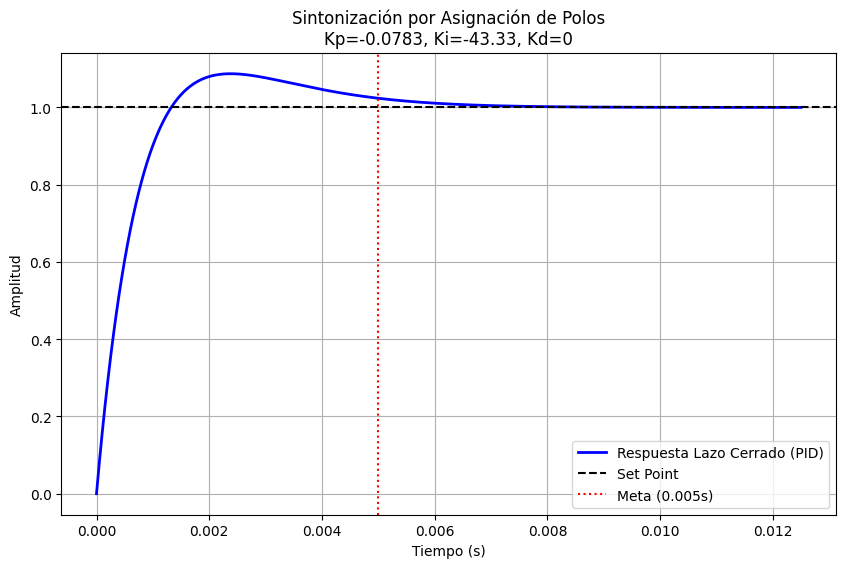


Información de la respuesta:
  - Sobreimpulso (Overshoot): 8.73%
  - Tiempo de Establecimiento (SettlingTime): 0.01 s
  - Valor final: 1.0000
  -Error en estado estacionario (1 -  valor_final): -0.0000


In [64]:
ts_deseado = 0.005   
zeta = 0.9          

wn = 4 / (zeta * ts_deseado)

Kp_calc = (2 * zeta * wn * T_planta - 1) / K_planta
Ki_calc = (wn**2 * T_planta) / K_planta
Kd_calc = 0  

print(f"\n--- RESULTADOS PID ---")
print(f"Objetivo: Estabilizar en {ts_deseado}s")
print(f"Kp = {Kp_calc:.6f}")
print(f"Ki = {Ki_calc:.6f}")
print(f"Kd = {Kd_calc:.6f}")

print("\n Funcion de trasnferencia")
print(Gp)

# Controlador PID Completo: Gc(s) = (Kd*s^2 + Kp*s + Ki) / s
num_c = [Kd_calc, Kp_calc, Ki_calc]
den_c = [1, 0]
Gc2 = ct.tf(num_c, den_c)

print("\n Funcion de trasnferencia PID")
print(Gc2)

# H(s) = (Gc*Gp) / (1 + Gc*Gp)
H2_closed_loop = ct.feedback(Gc2 * Gp, 1)

print("\n Funcion de trasnferencia Lazo cerrado")
print(H2_closed_loop)

t_sim = np.linspace(0, ts_deseado * 2.5, 1000)
t, y = ct.step_response(H2_closed_loop, T=t_sim)

plt.figure(figsize=(10, 6))
plt.plot(t, y, 'b-', linewidth=2, label='Respuesta Lazo Cerrado (PID)')
plt.axhline(1.0, color='k', linestyle='--', label='Set Point')
plt.axvline(ts_deseado, color='r', linestyle=':', label=f'Meta ({ts_deseado}s)')

plt.title(f'Sintonización por Asignación de Polos\nKp={Kp_calc:.4f}, Ki={Ki_calc:.2f}, Kd={Kd_calc}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()
plt.show()

info_tuned = ct.step_info(H2_closed_loop)
print("\nInformación de la respuesta:")
print(f"  - Sobreimpulso (Overshoot): {info_tuned['Overshoot']:.2f}%")
print(f"  - Tiempo de Establecimiento (SettlingTime): {info_tuned['SettlingTime']:.2f} s")
valor_final = y[-1]
print(f"  - Valor final: {valor_final:.4f}")
print(f"  -Error en estado estacionario (1 -  valor_final): {1 - valor_final:.4f}")